<IPython.core.display.Javascript object>


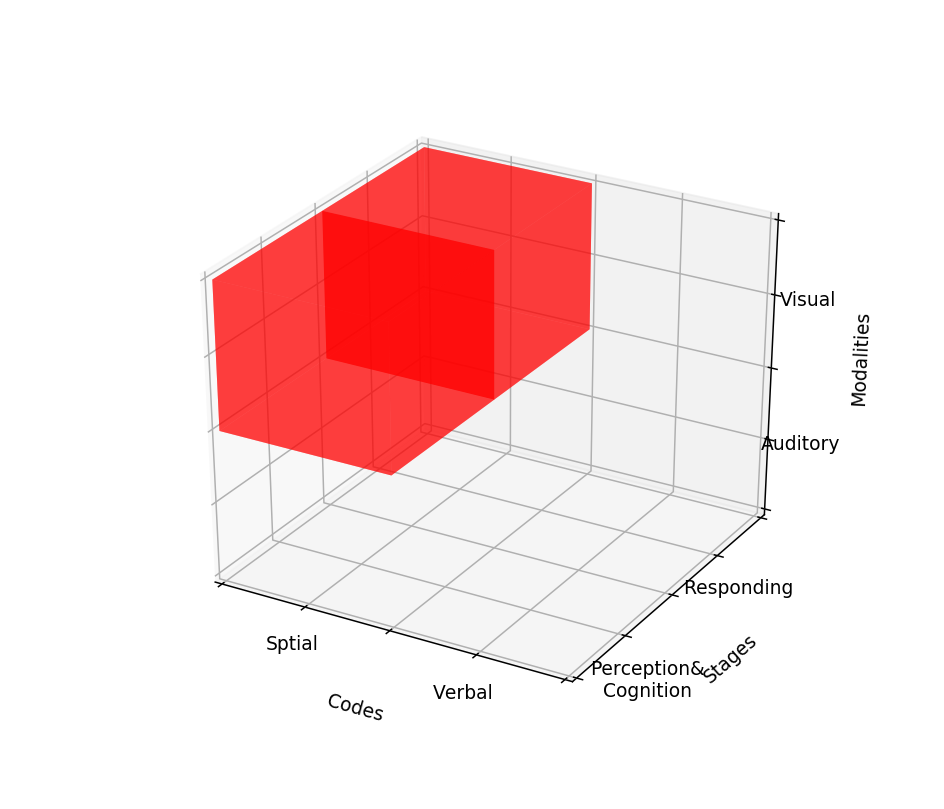

In [1]:
'''
Author  : Jiayao Yu, User Interfaces Group, Aalto University
Init    : August, 2017
Project : ELEC-D7010 Engineering for Humans course materials
Topic   : Multiple Resource Theory
===========================================================================
Usage explanation
------
where's reference from?
Multiple Resource Theory is to predict the relative differences in task
interference between different task configurations.

parameters shorthand explainations
------
      Task Analysis Shell: PC = Perception & Cognition, R = Responding,
                          V (under Modalities) = Visual, A = Auditory,
                          V (under Codes) = Verbal, S = Spatial
      Conflict Matrix: A and V in the first position = Auditory and Visual
                      V and S in the second position = Verbal and spatial
                      C = Cognitive, R = Response
Model limitations
------
1) assuming all tasks are alike
'''

import tkinter as tk
from tkinter import ttk
import numpy as np
import matplotlib as mpl
from IPython import display
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

class MRT(tk.Frame):
	tasks = ['driving', 
			'reading-map', 
			'listening-navigation']
	tasksAnalysis = ['S PC+R V',
					'S PC+R V',
					'V PC A']
	taskAnalysisValues = [[1, 0, 1, 1, 0, 1], 
						[1, 0, 1, 1, 0, 1], 
						[0, 1, 1, 0, 1, 0]]     # taskAnalysisValues[task][Perception&Cognition Responding Visual Auditory Verbal Spatial]
	maxTaskSelection = 2
	indexSelectedTask = []		# index of 2 selected tasks

	def __init__(self, parent=None):
		tk.Frame.__init__(self, parent)
		self.pack()
		self.makeWidgets()
		self.taskAnalysis()
		self.cubeVis()
		self.interference()

	def makeWidgets(self):
		self.frameTaskSelection = tk.Frame(self)
		self.frameTaskAnalysis = tk.Frame(self)
		self.frameConflictMatrix = tk.Frame(self)
		self.frameCubeVis = tk.Frame(self)
		self.frameTaskSelection.grid(row=0, column=0, sticky=tk.NSEW)
		self.frameTaskAnalysis.grid(row=1, column=0, sticky=tk.NSEW)
		self.frameConflictMatrix.grid(row=2, column=0, sticky=tk.NSEW)
		self.frameCubeVis.grid(row=3, column=0, sticky=tk.NSEW)
		self.btnsTask = []
		for i in range(len(self.tasks)):
			n = tk.Button(self.frameTaskSelection, text=self.tasks[i], width=20)
			self.btnsTask.append(n)
			self.btnsTask[-1].grid(row=i, column=0, sticky=tk.NSEW)
			self.btnsTask[-1].bind('<ButtonPress-1>', self.taskSelection)
	
	def taskSelection(self, event):
		for i in range(len(self.tasks)):
			if event.widget is self.btnsTask[i]:
				if self.btnsTask[i].cget('bg') == 'green':
					self.btnsTask[i].config(bg='SystemButtonFace', fg='black')
					if i in self.indexSelectedTask:
						self.indexSelectedTask.remove(i)
				else:
					if len(self.indexSelectedTask) < self.maxTaskSelection:
						self.btnsTask[i].config(bg='green', fg='white')
						self.indexSelectedTask.append(i)
		for i in range(len(self.tasks)):
			if i in self.indexSelectedTask:
				self.tableTaskAnalysisShell.tag_configure(i, background='green', foreground='white')
			else:
				self.tableTaskAnalysisShell.tag_configure(i, background='white', foreground='black')
		self.cubeVis()
		self.interference()

	def taskAnalysis(self):
		self.tableTaskAnalysisShell = ttk.Treeview(self.frameTaskAnalysis, columns=('codes', 'stages', 'modalities'), selectmode="browse")
		self.labelTaskAnalysisTitle = tk.Label(self.frameTaskAnalysis, text="Task Analysis Shell", anchor=tk.CENTER)
		self.tableTaskAnalysisShell.grid(row=0, column=0)
		self.labelTaskAnalysisTitle.grid(row=1, column=0)
		self.tableTaskAnalysisShell.column('#0', width=100)
		self.tableTaskAnalysisShell.column('codes', width=70, stretch=True)
		self.tableTaskAnalysisShell.column('stages', width=70, stretch=True)
		self.tableTaskAnalysisShell.column('modalities', width=70, stretch=True)
		self.tableTaskAnalysisShell.heading('codes', text='Codes')
		self.tableTaskAnalysisShell.heading('stages', text='Stages')
		self.tableTaskAnalysisShell.heading('modalities', text='Modalities')
		for i in range(len(self.tasks)):
			self.tableTaskAnalysisShell.insert('', i, self.tasks[i], text=self.tasks[i], tags=i, values=self.tasksAnalysis[i])

	def cubeVis(self):
		# legend
		fig = plt.figure(figsize=(7,6), dpi=100, facecolor='w', edgecolor='k')
		ax = fig.add_subplot(111, projection='3d')
		# labelling dimensions and associated levels
		labelAxis = ['Codes', 'Stages', 'Modalities']
		labelLevels = [['', 'Sptial', '', 'Verbal', ''], 
						['', 'Perception&\nCognition', '', 'Responding', ''], 
						['', 'Auditory', '', 'Visual', '']]
		xLabel = ax.set_xlabel(labelAxis[0], rotation='horizontal', labelpad=10)
		yLabel = ax.set_ylabel(labelAxis[1], rotation='horizontal', labelpad=10)
		zLabel = ax.set_zlabel(labelAxis[2], rotation='horizontal', labelpad=10)
		axisTicks = (-1, -0.5, 0, 0.5, 1)
		ax.set_xlim(-1,1)
		ax.set_xticks(axisTicks)
		ax.set_xticklabels(labelLevels[0])
		ax.set_ylim(-1,1)
		ax.set_yticks(axisTicks)
		ax.set_yticklabels(labelLevels[1])
		ax.set_zlim(-1,1)
		ax.set_zticks(axisTicks)
		ax.set_zticklabels(labelLevels[2])
		# determine associated cube vertices according to task selection
		r = 1
		x, y, z = ([0] for m in range(3))
		for i in range(len(self.indexSelectedTask)):
			for j in range(len(self.taskAnalysisValues[self.indexSelectedTask[i]])):
				if self.taskAnalysisValues[self.indexSelectedTask[i]][j]:
					if j < 2:
						x.append(np.sign(j-0.5))
					elif j < 4:
						y.append(np.sign(j-2.5))
					elif j < 6:
						z.append(np.sign(j-4.5))
		vertices = list(product(x, y, z))
		bufferVertices = [(1.0,1.0,1.0), (-1.0,1.0,1.0),(-1.0,-1.0,1.0),(1.0,-1.0,1.0),(1.0,1.0,-1.0),(-1.0,1.0,-1.0),(-1.0,-1.0,-1.0),(1.0,-1.0,-1.0)]
		bufferFaces = [[[[0,0,0],[1,0,0],[1,1,0],[0,1,0]],[[0,0,1],[1,0,1],[1,1,1],[0,1,1]],[[0,0,0],[1,0,0],[1,0,1],[0,0,1]],[[0,1,0],[1,1,0],[1,1,1],[0,1,1]],[[1,0,0],[1,1,0],[1,1,1],[1,0,1]],[[0,0,0],[0,1,0],[0,1,1],[0,0,1]]],
						[[[-1,0,0],[0,0,0],[0,1,0],[-1,1,0]],[[-1,0,1],[0,0,1],[0,1,1],[-1,1,1]],[[-1,0,0],[0,0,0],[0,0,1],[-1,0,1]],[[-1,1,0],[0,1,0],[0,1,1],[-1,1,1]],[[0,0,0],[0,1,0],[0,1,1],[0,0,1]],[[-1,0,0],[-1,1,0],[-1,1,1],[-1,0,1]]],
						[[[-1,-1,0],[0,-1,0],[0,0,0],[-1,0,0]],[[-1,-1,1],[0,-1,1],[0,0,1],[-1,0,1]],[[-1,-1,0],[0,-1,0],[0,-1,1],[-1,-1,1]],[[-1,0,0],[0,0,0],[0,0,1],[-1,0,1]],[[0,-1,0],[0,0,0],[0,0,1],[0,-1,1]],[[-1,-1,0],[-1,0,0],[-1,0,1],[-1,-1,1]]],
						[[[0,-1,0],[1,-1,0],[1,0,0],[0,0,0]],[[0,-1,1],[1,-1,1],[1,0,1],[0,0,1]],[[0,-1,0],[1,-1,0],[1,-1,1],[0,-1,1]],[[0,0,0],[1,0,0],[1,0,1],[0,0,1]],[[1,-1,0],[1,0,0],[1,0,1],[1,-1,1]],[[0,-1,0],[0,0,0],[0,0,1],[0,-1,1]]],
						[[[0,0,-1],[1,0,-1],[1,1,-1],[0,1,-1]],[[0,0,0],[1,0,0],[1,1,0],[0,1,0]],[[0,0,-1],[1,0,-1],[1,0,0],[0,0,0]],[[0,1,0],[0,1,-1],[1,1,-1], [1,1,0]],[[1,0,-1],[1,1,-1],[1,1,0],[1,0,0]],[[0,0,-1],[0,1,-1],[0,1,0],[0,0,0]]],
						[[[-1,0,-1],[0,0,-1],[0,1,-1],[-1,1,-1]],[[-1,0,0],[0,0,0],[0,1,0],[-1,1,0]],[[-1,0,-1],[0,0,-1],[0,0,0],[-1,0,0]],[[-1,1,-1],[0,1,-1], [0,1,0],[-1,1,0]],[[0,0,-1],[0,1,-1],[0,1,0],[0,0,0]],[[-1,0,-1],[-1,1,-1],[-1,1,0],[-1,0,0]]],
						[[[-1,-1,-1],[0,-1,-1],[0,0,-1],[-1,0,-1]],[[-1,-1,0],[0,-1,0],[0,0,0],[-1,0,0]],[[-1,-1,-1],[0,-1,-1],[0,-1,0],[-1,-1,0]],[[-1,0,-1], [0,0,-1],[0,0,0],[-1,0,0]],[[0,-1,-1],[0,0,-1],[0,0,0],[0,-1,0]],[[-1,-1,-1],[-1,0,-1],[-1,0,0],[-1,-1,0]]],
						[[[0,-1,-1],[1,-1,-1],[1,0,-1],[0,0,-1]],[[0,-1,0],[1,-1,0],[1,0,0],[0,0,0]],[[0,-1,0],[0,-1,-1],[1,-1,-1],[1,-1,0]],[[0,0,-1],[1,0,-1], [1,0,0],[0,0,0]],[[1,-1,-1],[1,0,-1],[1,0,0],[1,-1,0]],[[0,-1,-1],[0,0,-1],[0,0,0],[0,-1,0]]]]
		for i in range(len(bufferVertices)):
			if vertices.count(bufferVertices[i]) == 1:
				collection = Poly3DCollection(bufferFaces[i],alpha=0.5,linewidths=1)
				collection.set_facecolor('green')
				ax.add_collection3d(collection)
			if vertices.count(bufferVertices[i]) > 1:
				collection = Poly3DCollection(bufferFaces[i],alpha=0.5,linewidths=1)
				collection.set_facecolor('red')
				ax.add_collection3d(collection)
		display.clear_output(wait=True)
		plt.show()

	def interference(self):
		pass


if __name__ == "__main__":
	root = tk.Tk()
	root.title("Multiple Resource Theory")
	MRT(root).mainloop()
	root.after(5, lambda: root.focus_force())

In [ ]:
tmpFaceRegulation = [((-1,-1),(0,-1),(0,0),(-1,0)),((0,-1),(1,-1),(1,0),(0,0)),((0,0),(1,0),(1,1),(0,1)),((0,0),(0,1),(-1,1),(-1,0))]
faceRegulation = combinations(tmpFaceRegulation,[(-1,0,1)])